 # LSTM - Le M√©morialiste S√©quentiel
M√©taphore : C'est un expert avec une excellente m√©moire √† court et √† long terme. Il lit l'histoire de vos donn√©es comme une phrase, mot par mot, et se souvient du contexte.

Comment il r√©fl√©chit : Il analyse une s√©quence de jours (par exemple, les 60 derniers jours).

Il poss√®de une "m√©moire interne" qui lui permet de retenir des informations importantes vues au d√©but de la s√©quence (par exemple, "nous sommes au d√©but d'une p√©riode de croissance").
Il fait d√©filer la s√©quence jour apr√®s jour, en mettant √† jour sa m√©moire.
√Ä la fin, il utilise tout ce qu'il a appris et retenu sur la s√©quence pour deviner le "mot" suivant (la valeur de l'NDVI du lendemain).
Sa grande force est de comprendre l'ordre des √©v√©nements. Il sait que "beaucoup de pluie" suivi de "beaucoup de soleil" n'a pas le m√™me effet que l'inverse.

Force principale : Th√©oriquement le plus puissant pour comprendre des dynamiques temporelles complexes.

Faiblesse principale : Tr√®s long et complexe √† entra√Æner, n√©cessite beaucoup de donn√©es et peut √™tre sujet √† des probl√®mes techniques (comme l'erreur loss: nan que nous avons vue).

In [1]:
# Installation des biblioth√®ques n√©cessaires
!pip install tensorflow scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Charger et pr√©parer les donn√©es fusionn√©es
df_final = pd.read_csv("data_fusionner_netoyeer.csv")
df_final['date'] = pd.to_datetime(df_final['date'])
df_final = df_final.set_index('date').sort_index()
print("‚úÖ Donn√©es charg√©es.")
print(df_final.head())
print(df_final.tail())
print(df_final.info())

‚úÖ Donn√©es charg√©es.
                NDVI  NDVI_smoothed  precipitation  temperature         RH
date                                                                      
2018-01-20  0.134869            NaN       0.000000    12.134522  57.697033
2018-01-22  0.078602            NaN       0.000000    14.060856  45.916110
2018-02-07  0.074299       0.097647       0.078841     5.807220  54.461943
2018-02-14  0.119501       0.109564       0.000000    13.289267  42.479021
2018-02-23  0.080963       0.111181       0.000000    14.516624  38.952163
                NDVI  NDVI_smoothed  precipitation  temperature         RH
date                                                                      
2024-11-20  0.143553       0.102539            0.0    17.146216  57.177976
2024-11-22  0.079536       0.113988            0.0    16.821888  44.651478
2024-11-29  0.104598       0.108077            0.0    20.752578  29.855633
2024-12-06  0.136830            NaN            0.0    18.309847  32.570570
2

In [2]:

# Charger et pr√©parer les donn√©es fusionn√©es
df_final = pd.read_csv("data_fusionner_netoyeer.csv")
df_final['date'] = pd.to_datetime(df_final['date'])
df_final = df_final.set_index('date').sort_index()
print("‚úÖ Donn√©es charg√©es.")
print(df_final.head())
print(df_final.tail())
print(df_final.info())

‚úÖ Donn√©es charg√©es.
                NDVI  NDVI_smoothed  precipitation  temperature         RH
date                                                                      
2018-01-20  0.134869            NaN       0.000000    12.134522  57.697033
2018-01-22  0.078602            NaN       0.000000    14.060856  45.916110
2018-02-07  0.074299       0.097647       0.078841     5.807220  54.461943
2018-02-14  0.119501       0.109564       0.000000    13.289267  42.479021
2018-02-23  0.080963       0.111181       0.000000    14.516624  38.952163
                NDVI  NDVI_smoothed  precipitation  temperature         RH
date                                                                      
2024-11-20  0.143553       0.102539            0.0    17.146216  57.177976
2024-11-22  0.079536       0.113988            0.0    16.821888  44.651478
2024-11-29  0.104598       0.108077            0.0    20.752578  29.855633
2024-12-06  0.136830            NaN            0.0    18.309847  32.570570
2

--- Statistiques Descriptives ---
             NDVI  NDVI_smoothed  precipitation  temperature          RH
count  329.000000     325.000000     329.000000   329.000000  329.000000
mean     0.115853       0.116003       0.244832    23.675857   33.327647
std      0.038485       0.019581       0.837372     7.319718   11.613460
min      0.069456       0.088910       0.000000     5.807220   11.585891
25%      0.084347       0.101844       0.000000    17.517000   24.177973
50%      0.106093       0.109803       0.000000    24.337928   31.977711
75%      0.132948       0.125935       0.074760    29.456844   41.698876
max      0.253773       0.184251      10.596684    37.471479   71.086975


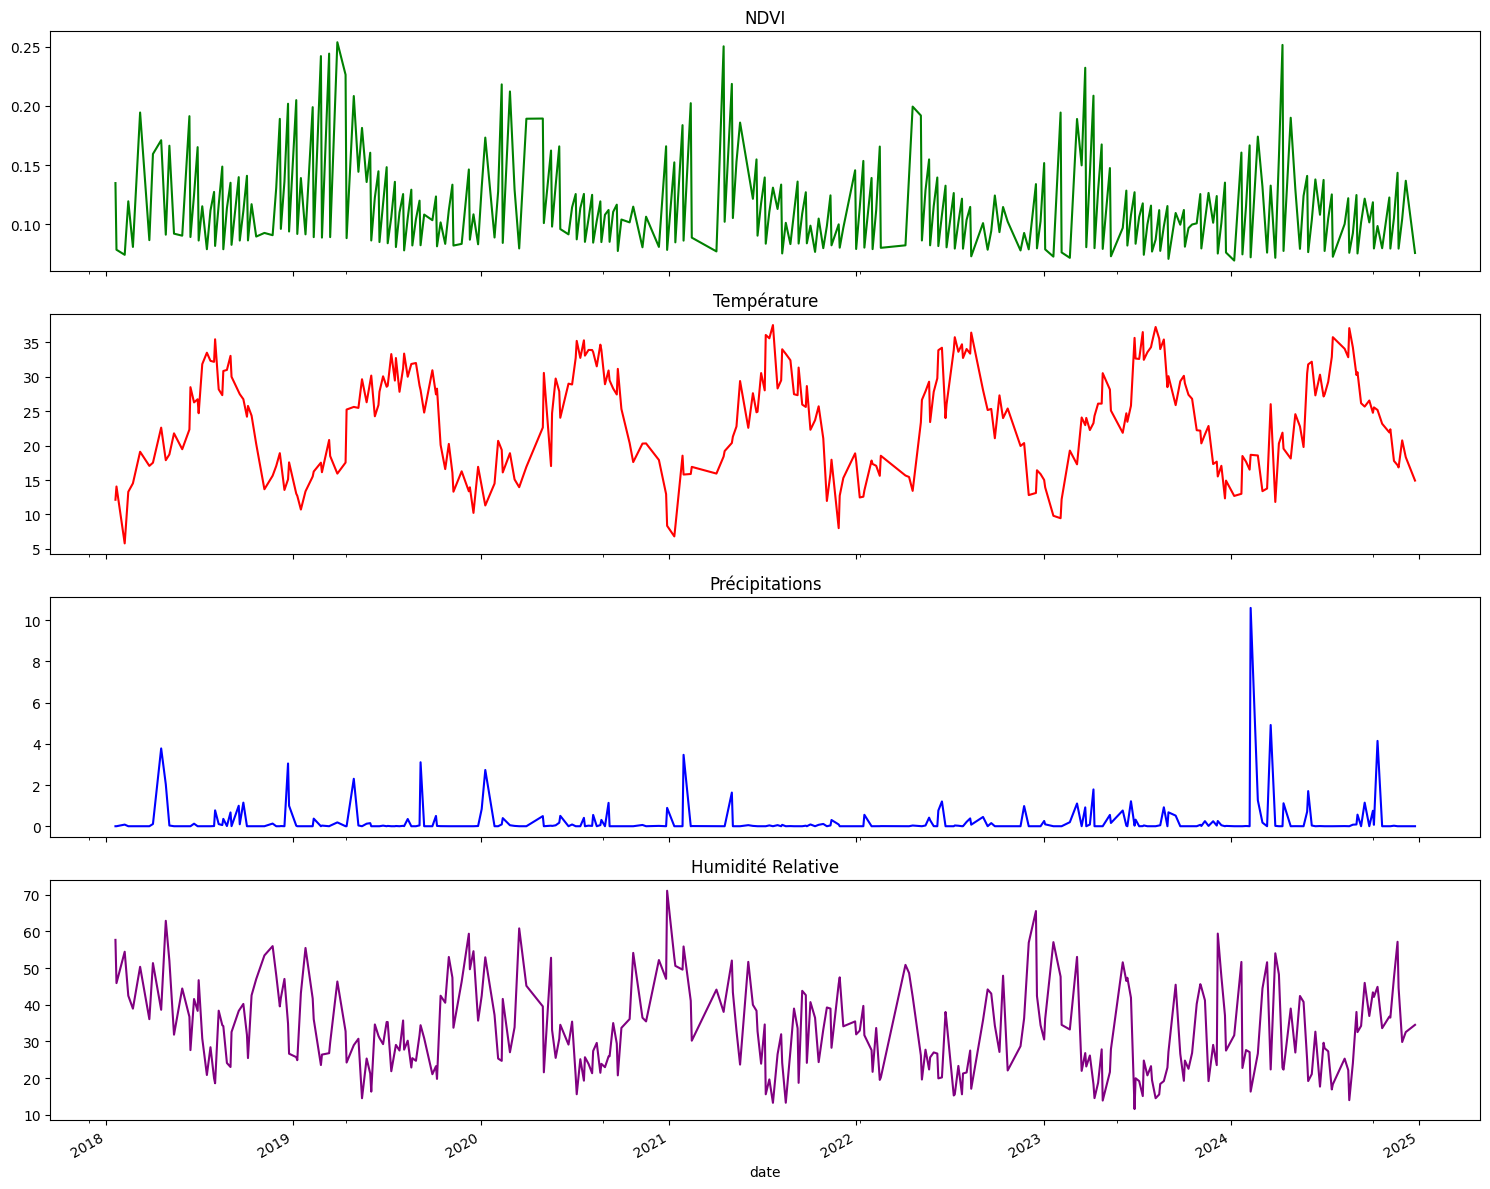

In [3]:
# Statistiques descriptives
print("--- Statistiques Descriptives ---")
print(df_final.describe())

# Visualisation des s√©ries
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
df_final['NDVI'].plot(ax=axes[0], title='NDVI', color='green')
df_final['temperature'].plot(ax=axes[1], title='Temp√©rature', color='red')
df_final['precipitation'].plot(ax=axes[2], title='Pr√©cipitations', color='blue')
df_final['RH'].plot(ax=axes[3], title='Humidit√© Relative', color='purple')
plt.tight_layout()
plt.show()

In [4]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df_final['NDVI'])
print(f'--- Test de Stationnarit√© (ADF) sur l\'NDVI ---')
print(f'p-value: {adf_result[1]}')

--- Test de Stationnarit√© (ADF) sur l'NDVI ---
p-value: 0.00048445159334313976


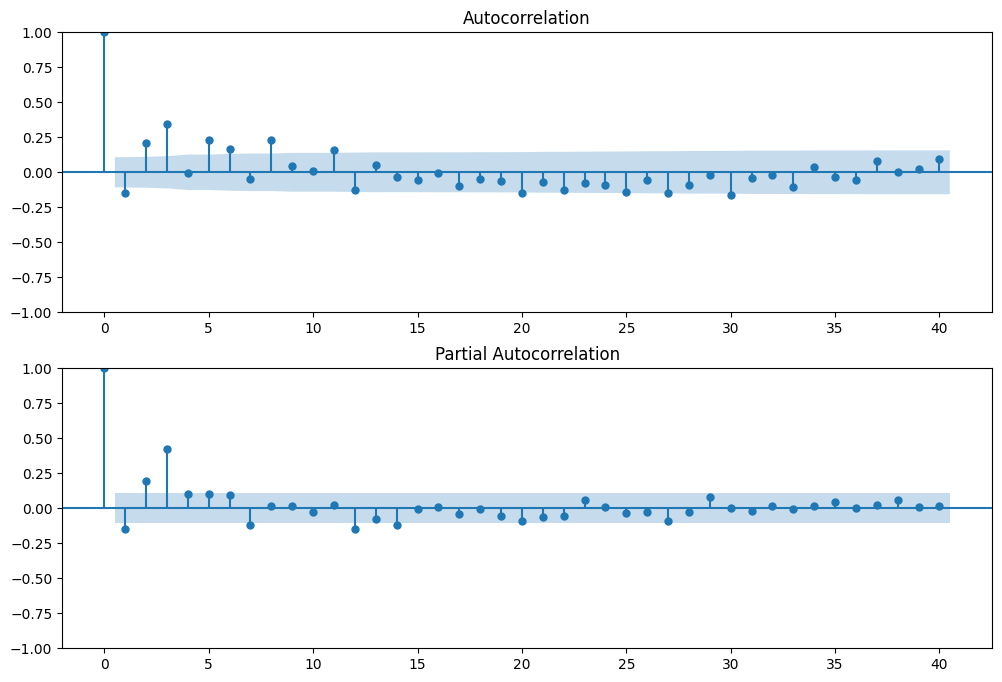

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_final['NDVI'], ax=ax1, lags=40)
plot_pacf(df_final['NDVI'], ax=ax2, lags=40)
plt.show()

In [6]:
import pandas as pd
import numpy as np

print("--- D√âBUT DU DIAGNOSTIC DES DONN√âES ---")
try:
    df = pd.read_csv("data_fusionner_netoyeer.csv")
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    print("\n1. V√©rification des valeurs manquantes (NaN) AVANT tout nettoyage :")
    print(df.isnull().sum())
    print("-" * 30)

    # Tentative de r√©paration plus robuste
    # Remplacer les infinis par des NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    print("\n2. V√©rification apr√®s avoir remplac√© les valeurs infinies (inf) :")
    print(f"Nombre total de valeurs manquantes (NaN + inf) : {df.isnull().sum().sum()}")
    print("-" * 30)

    # Combler tous les NaNs restants
    # d'abord avec l'interpolation, puis en propageant la valeur suivante pour le d√©but
    df.interpolate(method='linear', inplace=True)
    df.bfill(inplace=True) # bfill comble les NaNs au d√©but du fichier

    print("\n3. V√©rification des valeurs manquantes APR√àS nettoyage complet :")
    print(df.isnull().sum())
    print("-" * 30)

    print("\n4. Statistiques descriptives finales (pour d√©tecter des valeurs aberrantes) :")
    print(df.describe())
    print("-" * 30)

    print("\n--- FIN DU DIAGNOSTIC ---")
    print("\nSi aucune valeur manquante n'est list√©e √† l'√©tape 3, les donn√©es sont pr√™tes.")
    print("Veuillez partager l'int√©gralit√© de cet output.")


except FileNotFoundError:
    print("‚ùå ERREUR : Le fichier 'data_fusionner_netoyeer.csv' est introuvable.")
except Exception as e:
    print(f"‚ùå Une erreur inattendue est survenue : {e}")

--- D√âBUT DU DIAGNOSTIC DES DONN√âES ---

1. V√©rification des valeurs manquantes (NaN) AVANT tout nettoyage :
NDVI             0
NDVI_smoothed    4
precipitation    0
temperature      0
RH               0
dtype: int64
------------------------------

2. V√©rification apr√®s avoir remplac√© les valeurs infinies (inf) :
Nombre total de valeurs manquantes (NaN + inf) : 4
------------------------------

3. V√©rification des valeurs manquantes APR√àS nettoyage complet :
NDVI             0
NDVI_smoothed    0
precipitation    0
temperature      0
RH               0
dtype: int64
------------------------------

4. Statistiques descriptives finales (pour d√©tecter des valeurs aberrantes) :
             NDVI  NDVI_smoothed  precipitation  temperature          RH
count  329.000000     329.000000     329.000000   329.000000  329.000000
mean     0.115853       0.115844       0.244832    23.675857   33.327647
std      0.038485       0.019523       0.837372     7.319718   11.613460
min      0.069456 

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

print("--- D√âBUT DU SCRIPT LSTM FINAL (CORRIG√â POUR KEYERROR) ---")

# --- √âTAPE 1: CHARGEMENT ET NETTOYAGE ---
try:
    df_final = pd.read_csv("data_fusionner_netoyeer.csv")
    print("‚úÖ Fichier de donn√©es charg√©.")
except FileNotFoundError:
    print("‚ùå ERREUR : Le fichier 'data_fusionner_netoyeer.csv' est introuvable.")
    exit()

df_final['date'] = pd.to_datetime(df_final['date'])
df_final = df_final.set_index('date').sort_index()

df_final.replace([np.inf, -np.inf], np.nan, inplace=True)
df_final.interpolate(method='linear', inplace=True)
df_final.bfill(inplace=True)

if 'NDVI_smoothed' in df_final.columns:
    df_final = df_final.drop(columns=['NDVI_smoothed'])
print("‚úÖ Donn√©es nettoy√©es.")


# --- √âTAPE 2: MOD√âLISATION LSTM ---
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_final)
scaler_ndvi = MinMaxScaler()
scaler_ndvi.fit(df_final[['NDVI']])

def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:(i + lookback), :])
        y.append(data[i + lookback, 0])
    return np.array(X), np.array(y)

lookback = 60
X_seq, y_seq = create_sequences(data_scaled, lookback)

split_ratio = 0.8
split_index = int(len(X_seq) * split_ratio)
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]
print(f"‚úÖ Donn√©es divis√©es : {len(X_train)} s√©quences pour l'entra√Ænement, {len(X_test)} pour le test.")

print("\n--- Construction et entra√Ænement du mod√®le LSTM ---")
model_lstm = Sequential([
    LSTM(70, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(35),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train,
               batch_size=32, epochs=60,
               validation_data=(X_test, y_test),
               verbose=0) # verbose=0 pour un entra√Ænement plus silencieux
print("‚úÖ Mod√®le entra√Æn√©.")






--- D√âBUT DU SCRIPT LSTM FINAL (CORRIG√â POUR KEYERROR) ---
‚úÖ Fichier de donn√©es charg√©.
‚úÖ Donn√©es nettoy√©es.
‚úÖ Donn√©es divis√©es : 215 s√©quences pour l'entra√Ænement, 54 pour le test.

--- Construction et entra√Ænement du mod√®le LSTM ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


‚úÖ Mod√®le entra√Æn√©.


In [ ]:

# D√©finir le nom du fichier pour votre mod√®le
nom_du_fichier_modele = 'modele_lstm_ndvi.keras'

# Sauvegarder le mod√®le complet (architecture + poids)
model_lstm.save(nom_du_fichier_modele)

print(f"‚úÖ Mod√®le sauvegard√© avec succ√®s dans le fichier : {nom_du_fichier_modele}")

In [34]:

# --- √âTAPE 3: PR√âDICTIONS FUTURES ---
print("\n--- Pr√©dictions Futures ---")
last_sequence = data_scaled[-lookback:]
future_predictions = []
current_sequence = last_sequence.copy()

# --- CORRECTION POUR LE KEYERROR ---
# 1. Cr√©er le template climatique moyen (qui aura des trous)
dayofyear_map = df_final.groupby(df_final.index.dayofyear)[['temperature', 'precipitation', 'RH']].mean()
# 2. Cr√©er un index complet pour tous les jours d'une ann√©e bissextile
full_day_index = pd.Index(range(1, 367))
# 3. Re-indexer le template pour le rendre complet, en comblant les trous
dayofyear_map_complete = dayofyear_map.reindex(full_day_index, method='ffill').bfill()
# --- FIN DE LA CORRECTION ---


for i in range(365):
    next_pred_scaled = model_lstm.predict(current_sequence[np.newaxis, :, :], verbose=0)
    future_predictions.append(next_pred_scaled[0, 0])

    next_day_vector = np.zeros(current_sequence.shape[1])
    next_day_vector[0] = next_pred_scaled[0, 0]

    current_date = df_final.index[-1] + pd.Timedelta(days=i + 1)
    day_of_year = current_date.dayofyear

    # On utilise notre template complet et sans trou
    clim_values = dayofyear_map_complete.loc[day_of_year].values

    mock_record = np.hstack([np.zeros((1,1)), clim_values.reshape(1,-1)])
    scaled_clim_values = scaler.transform(mock_record)[0, 1:]
    next_day_vector[1:] = scaled_clim_values

    current_sequence = np.vstack([current_sequence[1:], next_day_vector])

future_predictions_real = scaler_ndvi.inverse_transform(np.array(future_predictions).reshape(-1, 1))
print("‚úÖ Pr√©dictions g√©n√©r√©es.")




--- Pr√©dictions Futures ---


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/valida

‚úÖ Pr√©dictions g√©n√©r√©es.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


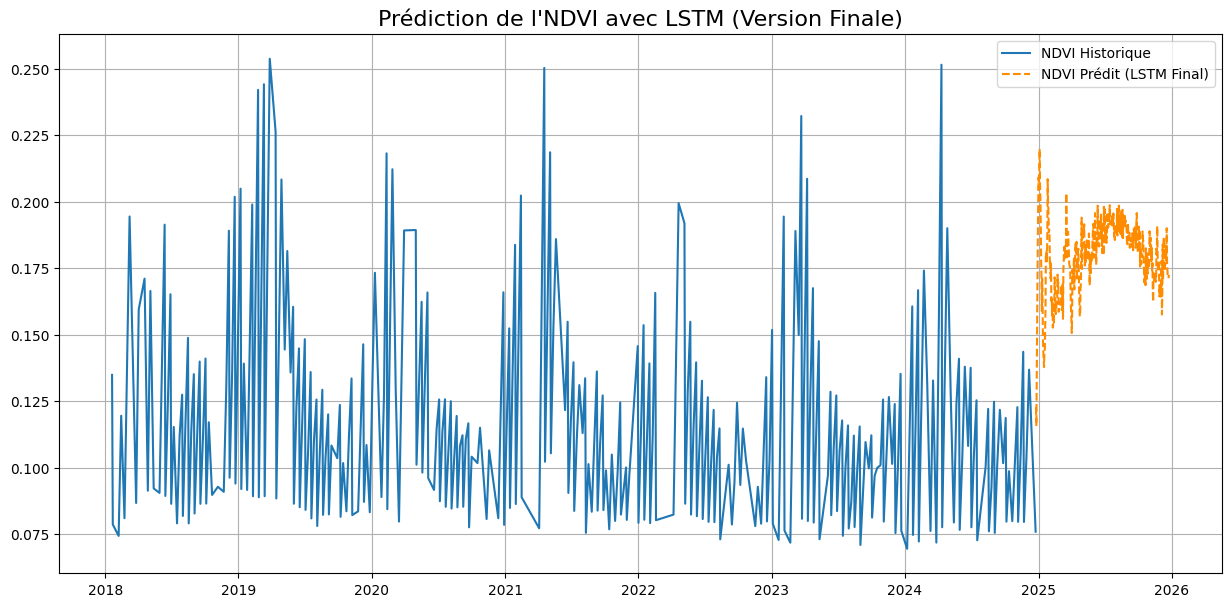

In [35]:

# --- √âTAPE 4: VISUALISATION FINALE ---
future_dates = pd.date_range(start=df_final.index[-1] + pd.Timedelta(days=1), periods=365)
plt.figure(figsize=(15, 7))
plt.plot(df_final.index, df_final['NDVI'], label='NDVI Historique')
plt.plot(future_dates, future_predictions_real, label='NDVI Pr√©dit (LSTM Final)', color='darkorange', linestyle='--')
plt.title("Pr√©diction de l'NDVI avec LSTM (Version Finale)", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 31ms/step 

--- Validation sur le jeu de test ---
MAE: 0.0254
RMSE: 0.0316


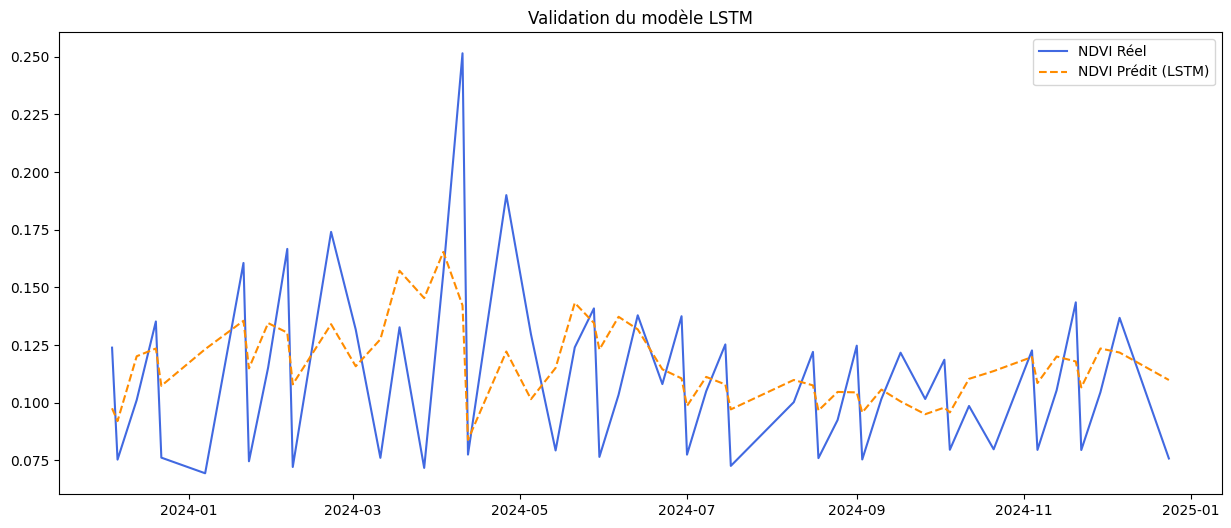

In [28]:
# Pr√©dictions sur le jeu de test
predictions_scaled = model_lstm.predict(X_test)

# D√©normalisation des pr√©dictions et des vraies valeurs
predictions = scaler_ndvi.inverse_transform(predictions_scaled)
y_test_real = scaler_ndvi.inverse_transform(y_test.reshape(-1, 1))

# M√©triques d'erreur
mae = mean_absolute_error(y_test_real, predictions)
rmse = np.sqrt(mean_squared_error(y_test_real, predictions))
print(f'\n--- Validation sur le jeu de test ---')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

# Visualisation des pr√©dictions vs valeurs r√©elles
plt.figure(figsize=(15, 6))
plt.plot(df_final.index[-len(y_test_real):], y_test_real, label='NDVI R√©el', color='royalblue')
plt.plot(df_final.index[-len(predictions):], predictions, label='NDVI Pr√©dit (LSTM)', color='darkorange', linestyle='--')
plt.title('Validation du mod√®le LSTM')
plt.legend()
plt.show()


--- Pr√©dictions Futures ---
üîÆ G√©n√©ration des pr√©dictions pour l'ann√©e suivante...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/valida

‚úÖ Pr√©dictions g√©n√©r√©es.


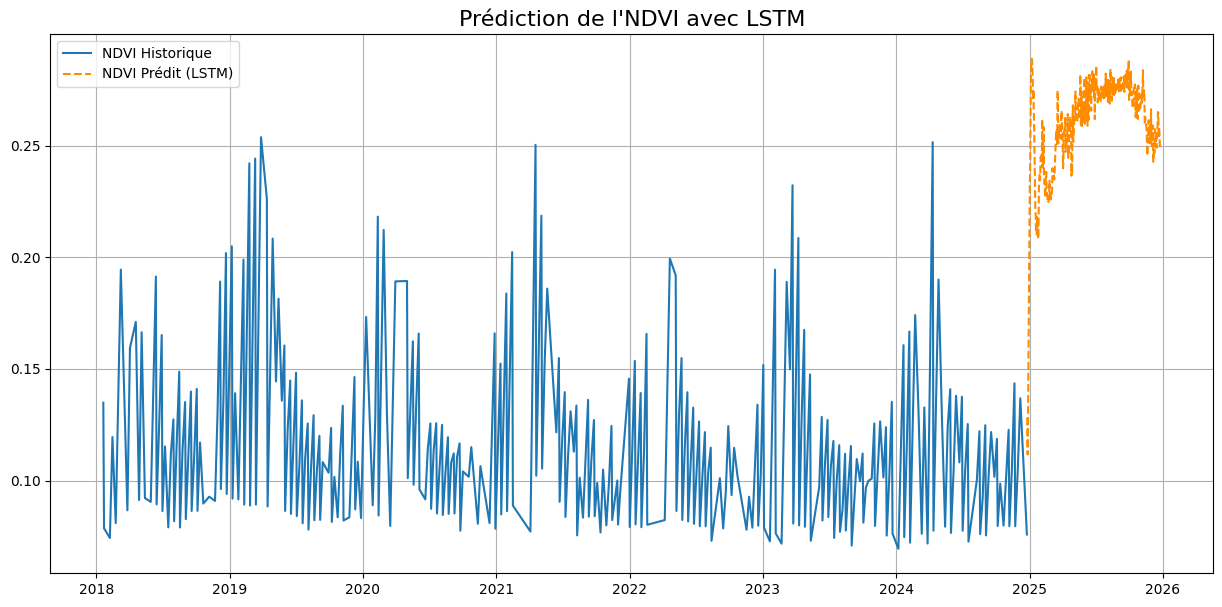

In [29]:
# --- √âTAPE 3 CORRIG√âE : PR√âDICTIONS FUTURES ---

print("\n--- Pr√©dictions Futures ---")

# On r√©cup√®re la derni√®re s√©quence de donn√©es r√©elles comme point de d√©part
last_sequence = data_scaled[-lookback:]
future_predictions = []
current_sequence = last_sequence.copy()

# --- LA CORRECTION EST ICI ---
# 1. Cr√©er le template climatique moyen (qui aura des trous)
dayofyear_map = df_final.groupby(df_final.index.dayofyear)[['temperature', 'precipitation', 'RH']].mean()

# 2. Cr√©er un index complet pour tous les jours d'une ann√©e (1 √† 366 pour √™tre s√ªr)
full_day_index = pd.Index(range(1, 367))

# 3. Re-indexer le template pour le rendre complet, en comblant les jours manquants
dayofyear_map_complete = dayofyear_map.reindex(full_day_index, method='ffill').bfill()
# --- FIN DE LA CORRECTION ---


# Boucle de pr√©diction jour par jour
print("üîÆ G√©n√©ration des pr√©dictions pour l'ann√©e suivante...")
for i in range(365):
    # Pr√©dire le jour suivant
    next_pred_scaled = model_lstm.predict(current_sequence[np.newaxis, :, :], verbose=0)
    future_predictions.append(next_pred_scaled[0, 0])

    # Cr√©er le vecteur du jour futur avec des donn√©es climatiques r√©alistes
    next_day_vector = np.zeros(current_sequence.shape[1])
    next_day_vector[0] = next_pred_scaled[0, 0] # Le NDVI pr√©dit

    # On r√©cup√®re le climat moyen pour ce jour futur √† partir du template complet
    current_date = df_final.index[-1] + pd.Timedelta(days=i + 1)
    day_of_year = current_date.dayofyear
    clim_values = dayofyear_map_complete.loc[day_of_year].values

    # On met √† l'√©chelle ces valeurs climatiques
    mock_record = np.hstack([np.zeros((1,1)), clim_values.reshape(1,-1)])
    scaled_clim_values = scaler.transform(mock_record)[0, 1:]
    next_day_vector[1:] = scaled_clim_values

    # On met √† jour la s√©quence pour la prochaine pr√©diction
    current_sequence = np.vstack([current_sequence[1:], next_day_vector])

# D√©normaliser la pr√©diction finale pour la rendre lisible
future_predictions_real = scaler_ndvi.inverse_transform(np.array(future_predictions).reshape(-1, 1))
print("‚úÖ Pr√©dictions g√©n√©r√©es.")


# --- VISUALISATION FINALE ---
future_dates = pd.date_range(start=df_final.index[-1] + pd.Timedelta(days=1), periods=365)
plt.figure(figsize=(15, 7))
plt.plot(df_final.index, df_final['NDVI'], label='NDVI Historique')
plt.plot(future_dates, future_predictions_real, label='NDVI Pr√©dit (LSTM)', color='darkorange', linestyle='--')
plt.title("Pr√©diction de l'NDVI avec LSTM", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

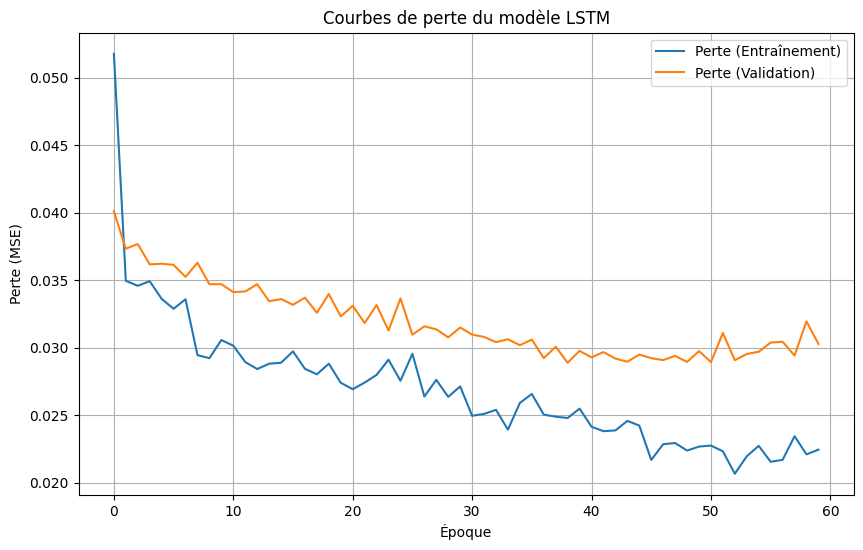

In [30]:
# Visualisation de l'historique de l'entra√Ænement
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Perte (Entra√Ænement)')
plt.plot(history.history['val_loss'], label='Perte (Validation)')
plt.title('Courbes de perte du mod√®le LSTM')
plt.xlabel('√âpoque')
plt.ylabel('Perte (MSE)')
plt.legend()
plt.grid(True)
plt.show()